In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [2]:
from util.plot import show_plot
#from sklearn import preprocessing

In [ ]:
tf.config.experimental.list_physical_devices('GPU') 

## Data work

### TODOs:
- api 下载CSV

```
http://api.money.126.net/data/feed/1000766
http://quotes.money.163.com/stocksearch/json.do?type=&count=1&word=st%E6%98%A5%E5%A4%A9
http://img1.money.126.net/data/hs/kline/day/history/2016/1000766.json
http://img1.money.126.net/data/hs/time/today/1000766.json
tick: http://quotes.money.163.com/cjmx/2017/20170626/1000766.xls

 ```

In [3]:
testfile="./data/300736.csv_.csv"
dfsrc = pd.read_csv(testfile)

numeric_features_name = ['收盘价', '最高价', '最低价', '开盘价', '前收盘',   '涨跌额',  '涨跌幅','成交量', '成交金额',"换手率"]
numeric_features =      ["close",   "high",   "low",  "open",   "pre_close","quote","quote_p","vol","vol_cash","turnover_rate"]

new_colmns = { k:v for k,v in zip(numeric_features_name,numeric_features)}
new_colmns["日期"]="date"

dfsrc = dfsrc.rename(columns=new_colmns)
#dfsrc = dfsrc[[v for _,v in new_colmns.items()]]
dfsrc[-5:]

,date,股票代码,名称,close,high,low,open,pre_close,quote,quote_p,turnover_rate,vol,vol_cash,总市值,流通市值
459,2018-01-15,'300736,百华悦邦,40.44,40.44,40.44,40.44,36.76,3.68,10.0109,0.1996,27101,1095964.44,2.196244e+09,549061968.0
460,2018-01-12,'300736,百华悦邦,36.76,36.76,36.76,36.76,33.42,3.34,9.9940,0.0656,8900,327164.00,1.996388e+09,499097872.0
461,2018-01-11,'300736,百华悦邦,33.42,33.42,33.42,33.42,30.38,3.04,10.0066,0.0295,4000,133680.00,1.814997e+09,453750024.0
462,2018-01-10,'300736,百华悦邦,30.38,30.38,30.38,30.38,27.62,2.76,9.9928,0.0118,1600,48608.00,1.649898e+09,412475336.0
463,2018-01-09,'300736,N百华,27.62,27.62,23.02,23.02,19.18,8.44,44.0042,0.0545,7400,203698.00,1.500006e+09,375002264.0


## TODO

- 加入均值 等更多特征
- 更多数据，选取欧几里得距离小于平均的 几个个股数据训练
- 超参调整，网络结构，已经正则化

In [4]:
#数据清洗
def clean_data(df):
    df = df[::-1]
    df = df.replace("None",np.nan)
    df = df.dropna()
    for k in numeric_features:
        df[k] = pd.to_numeric(df[k])
    return df

#bins = pd.IntervalIndex.from_tuples([(0, 1), (2, 3), (4, 5)]) 
#pd.cut([0, 0.5, 1.5, 2.5, 4.5], bins)
def bucket_hl(x):
    bucket = [-5,-3,-1,1,3,5]
    #lables = ("大跌","跌","小跌"，"横盘","小涨","涨","大涨")    
    if x <= bucket[0]:
        return -1
    
    for i in range(len(bucket)-1):
        if x >bucket[i] and x<=bucket[i+1]:
            return i     
    return len(bucket)

def bucket_dw(x):
    if x ==0:
        return "1_day"
    if x ==4:
        return "5_day"
    return "mid_day"

#初步特征工程
def feature_eng(df):
    
    df["date"]=pd.to_datetime(df["date"])
    df["dayofweek"] = df["date"].dt.dayofweek
    df["dayofweek"] = df["dayofweek"].apply(bucket_dw).astype(str)
    df_dw_bucket = pd.get_dummies(df["dayofweek"])
    
    #振动幅度-%
    df["hl_p"] = 100*(df["high"]-df["low"])/df["pre_close"]
    df["quote_p"] = df["quote_p"].apply(lambda x: 1 if x>0 else 0)

    df = pd.concat([df,df_dw_bucket],axis=1)
        
    return df

In [5]:
df = clean_data(dfsrc)
df = feature_eng(df)

In [6]:

df[-5:].columns

Index(['date', '股票代码', '名称', 'close', 'high', 'low', 'open', 'pre_close',
       'quote', 'quote_p', 'turnover_rate', 'vol', 'vol_cash', '总市值', '流通市值',
       'dayofweek', 'hl_p', '1_day', '5_day', 'mid_day'],
      dtype='object')

In [7]:
df.dtypes

date             datetime64[ns]
股票代码                     object
名称                       object
close                   float64
high                    float64
low                     float64
open                    float64
pre_close               float64
quote                   float64
quote_p                   int64
turnover_rate           float64
vol                       int64
vol_cash                float64
总市值                     float64
流通市值                    float64
dayofweek                object
hl_p                    float64
1_day                     uint8
5_day                     uint8
mid_day                   uint8
dtype: object

In [8]:
selected_features = ["quote_p","hl_p","vol","close","turnover_rate",'1_day', '5_day', 'mid_day']
df_truck = df[selected_features]
df_truck.index = df["date"]
df_truck[-10:]

,quote_p,hl_p,vol,close,turnover_rate,1_day,5_day,mid_day
date,,,,,,,,
2019-11-22,0,4.264973,4542632,10.60,5.4021,0,1,0
2019-11-25,0,4.339623,3234920,10.40,3.8470,1,0,0
2019-11-26,0,1.346154,1773947,10.37,2.1096,0,0,1
2019-11-27,0,2.700096,1556100,10.35,1.8505,0,0,1
2019-11-28,0,2.608696,1674807,10.30,1.9917,0,0,1
2019-11-29,1,1.553398,1343190,10.36,1.5973,0,1,0
2019-12-02,0,1.544402,1335480,10.28,1.5882,1,0,0
2019-12-03,1,2.237354,1717660,10.37,2.0427,0,0,1
2019-12-04,1,1.542912,1406980,10.42,1.6732,0,0,1


In [9]:
df_truck["quote_p"].value_counts()

1    246
0    218
Name: quote_p, dtype: int64

In [11]:

def make_window_dataset(ds, window_size=5, shift=1, stride=1):
    """
    While using Dataset.batch works, there are situations where you may need finer control. 
    The Dataset.window method gives you complete control, 
    but requires some care: it returns a Dataset of Datasets. See Dataset structure for details.
    """
    windows = ds.window(window_size, shift=shift, stride=stride)
    
    def sub_to_batch(sub):
        return sub.batch(window_size, drop_remainder=True)
    windows = windows.flat_map(sub_to_batch)
    return windows

#target_name = "quote_p"
def split_df(dataframe,selected_features,targetnames):
    y = dataframe[targetnames].values
    x = dataframe[selected_features].values
    return x,y

X_W_Size=10
def convert_ds(x,y,y_step=3,x_window_size=X_W_Size,shift=1,stride=1):
    y = tf.data.Dataset.from_tensor_slices(y[x_window_size:])
    y = make_window_dataset(y,y_step,shift=shift,stride=stride)
    
    x = tf.data.Dataset.from_tensor_slices(x)
    x = make_window_dataset(x,x_window_size,shift=shift,stride=stride)    
    return x,y

def split_val(x,rate=0.3):
    v = int(len(x)*rate)
    return x[:-v],x[-v:]

def stder(x):
    mean = x.mean(axis=0)
    std = x.std(axis=0)
    return (x-mean)/std

In [12]:
x,y = split_df(df_truck,selected_features[1:],targetnames=["quote_p"])
x = stder(x)

train_x,val_x = split_val(x)
train_y,val_y = split_val(y)


In [13]:
BUFFER_SIZE = 64
BATCH_SIZE = 32
train_data = tf.data.Dataset.zip( (convert_ds(train_x,train_y)) )
val_data = tf.data.Dataset.zip( (convert_ds(val_x,val_y)) )
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data = val_data.batch(BATCH_SIZE).repeat()

Guid [feature_columns](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/zh-cn/tutorials/structured_data/feature_columns.ipynb#scrollTo=mxwiHFHuNhmf) 

```python
#from tensorflow import feature_column
example_batch = next(iter(train_ds))[0]
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

```


In [14]:
from tensorflow.keras import layers
def StockModel(x_shape,y_step=3,learning_rate=0.001,loss='mae'):
    print("Input Shape:",x_shape)
    model = tf.keras.models.Sequential()
    model.add(layers.LSTM(32,return_sequences=True,input_shape=x_shape))
    model.add(layers.LSTM(16, activation='relu'))
    #model.add(layers.LSTM(16))
    model.add(layers.Dense(y_step))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mae')
    return model

In [15]:
model = StockModel((X_W_Size,len(selected_features)-1,))

Input Shape: (10, 7)


In [19]:
EVALUATION_INTERVAL = 100
EPOCHS = 100


In [20]:
#GPU
history = model.fit(train_data, epochs=EPOCHS,
                        steps_per_epoch=EVALUATION_INTERVAL,
                        validation_data=val_data,
                        validation_steps=50)

Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 [==============================] - 3s 32ms/step - loss: 1.9260 - val_loss: 4.2343
Epoch 2/100
100/100 [==============================] - 3s 31ms/step - loss: 1.8787 - val_loss: 3.9353
Epoch 3/100
100/100 [==============================] - 3s 31ms/step - loss: 1.8502 - val_loss: 4.0145
Epoch 4/100
100/100 [==============================] - 3s 31ms/step - loss: 1.8401 - val_loss: 4.0936
Epoch 5/100
100/100 [==============================] - 3s 31ms/step - loss: 1.7875 - val_loss: 4.2281
Epoch 6/100
100/100 [==============================] - 3s 31ms/step - loss: 1.7726 - val_loss: 4.0262
Epoch 7/100
100/100 [==============================] - 3s 31ms/step - loss: 1.7442 - val_loss: 4.1615
Epoch 8/100
100/100 [==============================] - 3s 31ms/step - loss: 1.6884 - val_loss: 4.0243
Epoch 9/100
100/100 [==============================] - 3s 31ms/step - loss: 1.6586 - val_loss: 4.0226
Epoch 10/100
100/100 [=================

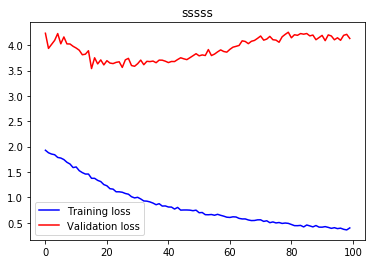

In [21]:
from util.plot import plot_train_history
plot_train_history(history,"sssss")